In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import snapatac2 as snap
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import pyranges as pr
import os
import warnings
import requests
# plt.rcdefaults()

import sys
sys.path.append('/scratch/eli')
from perturbseq import *

In [39]:
def prep_assignment_dataset(guide_call_summary, sample_id, library_id):

    df = pd.read_csv(guide_call_summary, index_col = 0).query(f"sample == '{sample_id}'")
    df['calls'] = df.n_guides.map(lambda n: '3+' if n in ['3','4+'] else str(n))
    df.rename({'pct_cells': 'pct_nuclei', 'count': 'n_cells'}, axis = 1, inplace = True)
    df = df[['calls', 'n_cells', 'pct_nuclei']].groupby('calls').sum().reset_index()
    df['library'] = library_id

    return df[['calls', 'n_cells', 'library', 'pct_nuclei']]

sirloinTSO_multiome_assignment = prep_assignment_dataset("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_outs/240428_run2_guide_call_summary.csv", sample_id = "Lane1_040", library_id='+SIRLOIN/TSO T7 (Multiome)')
sirloinTSO_multiome_assignment

,calls,n_cells,library,pct_nuclei
0,0,2980,+SIRLOIN/TSO T7 (Multiome),31.981112
1,1,4969,+SIRLOIN/TSO T7 (Multiome),53.326894
2,2,1151,+SIRLOIN/TSO T7 (Multiome),12.352436
3,3+,218,+SIRLOIN/TSO T7 (Multiome),2.339558


In [36]:
dc_assignment = pd.read_csv("/data/norman/eli/T7/202312_RPE1e150DC/10x_GuideLib/10x_manual_calling.csv")
dc_assignment['called'] = dc_assignment.called.map(lambda x: '3+' if x in ['3','4+'] else str(x))
df = dc_assignment.query("condition == 'Dig'").called.value_counts(normalize = True).to_frame().map(lambda x: x * 100).reset_index()
df['library'] = '10x Direct Capture (3\' GEX)'
df.columns = ['calls', 'pct_nuclei', 'library']
df

,calls,pct_nuclei,library
0,1,57.762381,10x Direct Capture (3' GEX)
1,0,32.276110,10x Direct Capture (3' GEX)
2,2,8.360277,10x Direct Capture (3' GEX)
3,3+,1.601232,10x Direct Capture (3' GEX)


In [40]:
df_plot = pd.concat([sirloinTSO_multiome_assignment, df], axis = 0).query("calls != '0'")
df_plot['calls'] = pd.Categorical(df_plot.calls, categories = ['3+', '2', '1'], ordered = True)

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 5.5 in image.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: outs/Syy_DC_assignment_comparison.pdf
2024-09-20 13:27:46 - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
2024-09-20 13:27:46 - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


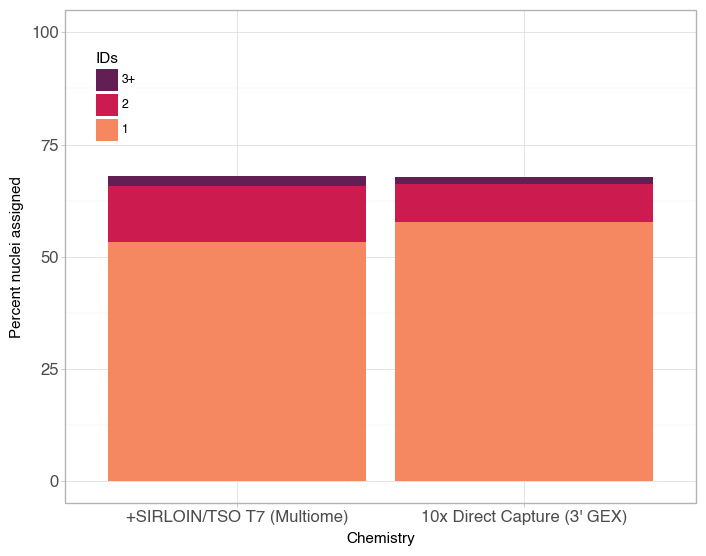

In [98]:
p = (
    ggplot(df_plot)
        + geom_col(aes(x = 'library', y = 'pct_nuclei', fill = 'calls'))
        + theme_light()
        + theme(text=element_text(family="Helvetica"))
        + theme(axis_text_x=element_text(size=12), 
                axis_text_y=element_text(size=12))
        + theme(figure_size=(7, 5.5))
        + theme(legend_position = (0.05,0.9))
        + ylim(0,100)
        + scale_fill_manual(sns.color_palette("rocket", 3).as_hex())
        + labs(x = 'Chemistry', y = 'Percent nuclei assigned', fill = 'IDs')
)
p.save("outs/Syy_DC_assignment_comparison.pdf", dpi = 300)
p.draw()

In [53]:
pop = CellPopulation.from_hdf("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files/gex_norm_regressed.hdf5")
df_guides = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_outs/Lane1_040_called_ids.csv")
df_guides['CB'] = df_guides.CB.map(lambda s: s + "-1")
df_singlets = df_guides.query("CB.isin(@pop.cells.index)")
df_singlets

Loading matrix...
Loading metadata...
Done in 0.960712194442749s.
Generating summary statistics...
Done.


,CB,identity,UMI,total_reads,cluster
0,AAACAGCCAGCCAGTT-1,YY1_GGCCGGGCCCGAGCAGAGTG,4.000000,10.308339,1
1,AAACAGCCAGGCTAAG-1,SMARCC2_GCCCGAGCCGGAGAAGATGG,4.087463,10.051209,1
2,AAACAGCCAGTTGCGT-1,DPF2_GCTGCGCGCTGCGGACTGTG,6.108524,13.156241,1
3,AAACATGCAAGGAATC-1,NTC_01615_GCCTGAACCGACCTACGAGG,3.807355,11.068778,1
5,AAACATGCATCCATCT-1,DPF2_GCTGCGCGCTGCGGACTGTG,3.584963,10.696098,1
...,...,...,...,...,...
7948,TTTGTGTTCGTGCCTT-1,SUZ12_GAGGCTCCGGCGGACCGAGG,4.807355,11.561765,1
7949,TTTGTGTTCTTGTTCG-1,SMARCC1_GGGTGCGCGCGGGAACGACC,4.700440,10.375039,1
7950,TTTGTTGGTCTCACTG-1,SMARCC2_GCCCGAGCCGGAGAAGATGG,3.169925,10.158610,1
7951,TTTGTTGGTGAGCGAA-1,NTC_03577_GCCCACTGGTCTTCACACAG,3.906891,10.707359,1


In [91]:
df_singlets['Perturbation target'] = df_singlets.identity.map(lambda i: i.split("_")[0])
df_singlets['Perturbation target'] = pd.Categorical(df_singlets['Perturbation target'], categories=['ACTL6A', 'ARID1A', 'DMAP1', 'DPF2', 'EP400', 'EZH2', 'NTC', 'SMARCA4', 'SMARCB1', 'SMARCC1', 'SMARCC2', 'SMARCE1', 'SUZ12', 'YY1'], ordered = True)

/tmp/ipykernel_39176/1754984372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_39176/1754984372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


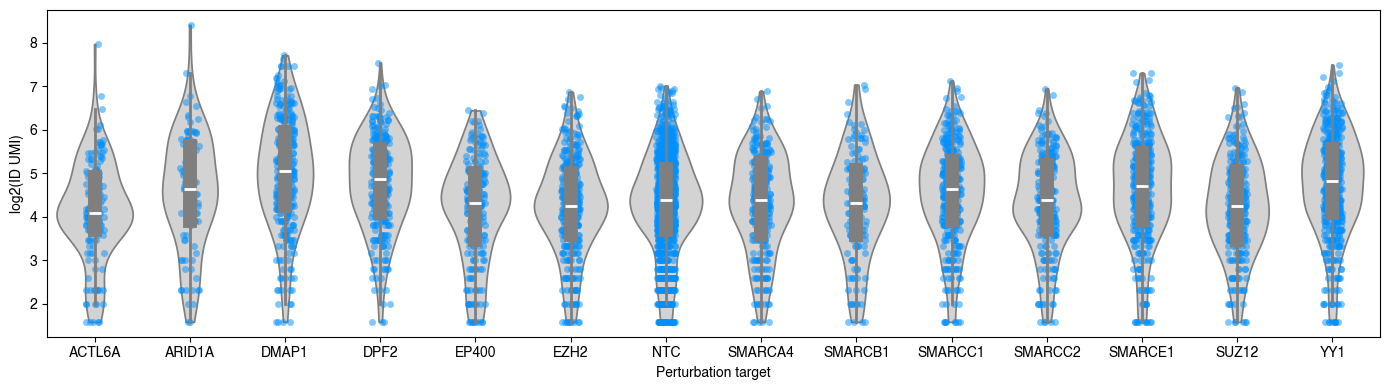

In [97]:
plt.figure(figsize=(14,4))
sns.violinplot(data = df_singlets, x = 'Perturbation target', y = 'UMI', color = 'lightgrey', cut = 0, inner_kws = dict(box_width=10, whis_width=2, zorder = 2))
sns.stripplot(data = df_singlets, x = 'Perturbation target', y = 'UMI', color = '#0390fc', alpha = 0.5, zorder = 1)
plt.ylabel("log2(ID UMI)")
plt.tight_layout()
plt.savefig("outs/Syy_guideUMI_violin.pdf")
plt.show()